# Driver Drowsiness Alert System

This Jupyter Notebook implements a real-time driver drowsiness detection system. It uses computer vision techniques to analyze a driver's face from a webcam feed, detects signs of fatigue like closed eyes or yawning, and triggers an alert.


# Overview
This notebook demonstrates three approaches for driver drowsiness detection included in this project:

- Dlib landmarks + EAR/MAR thresholds (lightweight, classic)
- MediaPipe Face Mesh + EAR/MAR (robust, modern)
- CNN classifier (learned model)

Use the sections below to run the approach you prefer. Each section has a short explanation, the code to start the webcam loop, and notes on when to use the approach.

---

# Table of Contents
1. Setup & Imports
2. Image-based demo (no webcam)
3. Log analysis demo
4. Drowsiness Detection (dlib landmarks)
5. Drowsiness Detection (MediaPipe Face Mesh)
6. Drowsiness Detection (CNN classifier)

---

In [ ]:
# # Install specific package versions to resolve dependency conflicts
# import sys
# !{sys.executable} -m pip install numpy==1.26.4 matplotlib==3.7.1 mediapipe


# Drowsiness Detection (dlib landmarks)

### Image based demo

DrowsinessAnalyzer(EAR_Threshold=0.2, EAR_Frames=20, MAR_Threshold=0.5)


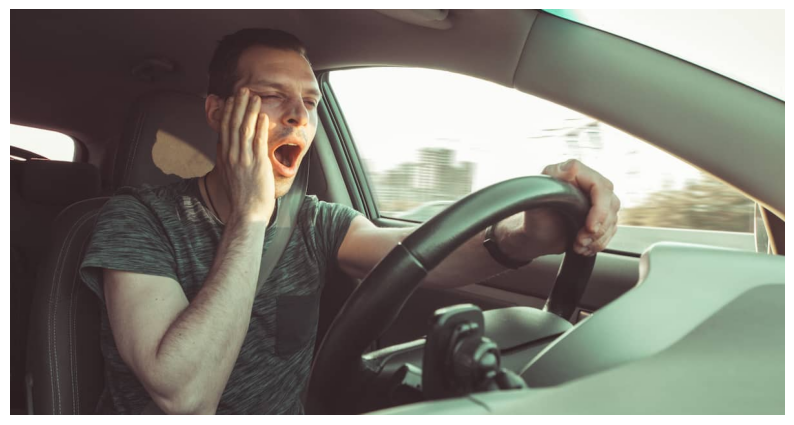

Drowsy: False Yawning: False


In [3]:
# 4. Image-based demo (no webcam)
# This cell lets you preview the overlay on a static image so you don't need a camera.
import os
import cv2
import matplotlib.pyplot as plt
from drowsiness.drowsiness_analyzer import DrowsinessAnalyzer

analyzer = DrowsinessAnalyzer()
print(analyzer)
# Path to a sample image you can add to the repo (optional)
img_path = 'sample_images/driver1.png'

if os.path.exists(img_path):
    img = cv2.imread(img_path)
else:
    # create a simple synthetic placeholder image if no sample image is present
    img = 255 * np.ones((480, 640, 3), dtype=np.uint8)
    cv2.putText(img, 'SAMPLE DRIVER', (40, 240), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)

# Run the analyzer (analyzer should already be created above)
try:
    annotated, is_drowsy, is_yawning = analyzer.analyze(img.copy())
except NameError:
    raise RuntimeError('`analyzer` is not defined. Run the "Initialize the Drowsiness Analyzer" cell first.')

# Convert BGR->RGB for inline display
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 7))
plt.imshow(annotated_rgb)
plt.axis('off')
plt.show()

print('Drowsy:', is_drowsy, 'Yawning:', is_yawning)

 ### WebCam Demo (dlib landmarks)
 This run uses the classic dlib-based landmark detector via `DrowsinessAnalyzer.analyze_frame`. It opens a webcam stream, overlays EAR/MAR and alerts, and keeps the window responsive until you press `q` or `Esc`. Use this when you want the lightest dependency set (no MediaPipe).

In [ ]:
from drowsiness.utils import run_drowsiness_detection_loop

# Run the detection loop with dlib-based analyzer
run_drowsiness_detection_loop(
    analyzer=analyzer,
    window_name="Drowsiness Detection",
    use_mediapipe=False
)

: 

# Drowsiness Detection (MediaPipe Face Mesh)

### Image based demo

/Users/kedar/Documents/pyproj/driver-drowsiness-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Testing with image from category 'Closed': data/drowsiness/Closed/_49.jpg


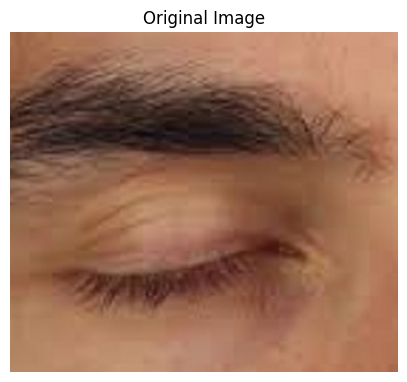

No face detected or image is already cropped. Using full image.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: Closed
Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: Closed
Confidence: 1.0000


In [2]:
# Predict on a sample image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.models import load_model
from drowsiness.cnn_utils import get_haarcascade_path, crop_mouth_from_face

def predict_image(image_path, model_path="models/drowsiness_cnn_trained.h5"):
    if not os.path.exists(model_path):
        print("Model not found. Please train it first.")
        return

    model = load_model(model_path)
    labels_new = ["yawn", "no_yawn", "Closed", "Open"]
    IMG_SIZE = 145
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image not found: {image_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    # Logic to handle different image types (full face vs cropped eye)
    # For demonstration, we'll try to detect a face/mouth first.
    # If it fails, we assume it's an eye image or already cropped.
    
    face_cas_path = get_haarcascade_path()
    cropped_mouth = crop_mouth_from_face(img, face_cas_path)
    
    input_array = None
    
    if cropped_mouth is not None:
        print("Face/Mouth detected. Using cropped mouth for prediction.")
        resized = cv2.resize(cropped_mouth, (IMG_SIZE, IMG_SIZE))
        plt.figure(figsize=(3, 3))
        plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Mouth")
        plt.axis('off')
        plt.show()
        input_array = resized
    else:
        print("No face detected or image is already cropped. Using full image.")
        input_array = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    normalized = input_array / 255.0
    reshaped = normalized.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    prediction = model.predict(reshaped)
    class_idx = np.argmax(prediction)
    print(f"Prediction: {labels_new[class_idx]}")
    print(f"Confidence: {prediction[0][class_idx]:.4f}")

# Test with a random image from the dataset
data_dir = "data/drowsiness"
if os.path.exists(data_dir):
    categories = ["yawn", "no_yawn", "Closed", "Open"]
    # Try to pick a random category and image
    found = False
    for _ in range(10): # Try 10 times to find a valid image
        cat = random.choice(categories)
        folder = os.path.join(data_dir, cat)
        if os.path.exists(folder) and len(os.listdir(folder)) > 0:
            img_name = random.choice(os.listdir(folder))
            img_path = os.path.join(folder, img_name)
            print(f"\nTesting with image from category '{cat}': {img_path}")
            predict_image(img_path)
            found = True
            break
    if not found:
        print("Could not find any images in dataset to test.")
else:
    print("Dataset not found. Please train the model to download it.")

### WebCam demo
This variant uses MediaPipe Face Mesh to get landmarks, then `DrowsinessAnalyzer.analyze_frame_mediapipe` for EAR/MAR, overlay, and logging. It mirrors the frame for a user-facing preview and shares the same capture/cleanup helper.

In [ ]:
from drowsiness.mediapipe_analyzer import MediapipeAnalyzer
from drowsiness.drowsiness_analyzer import DrowsinessAnalyzer
from drowsiness.utils import run_drowsiness_detection_loop

# Initialize analyzers
mediapipe_analyzer = MediapipeAnalyzer()
drowsiness_analyzer = DrowsinessAnalyzer()

# Run the detection loop with MediaPipe analyzer
run_drowsiness_detection_loop(
    analyzer=drowsiness_analyzer,
    window_name="Drowsiness Detection (MediaPipe)",
    mediapipe_analyzer=mediapipe_analyzer,
    use_mediapipe=True
)

# Drowsiness Detection (CNN classifier)

### Training the CNN model 
can be skipped, since pre trained model using this method is available in models folder.

### CNN Model training

In [ ]:
# Train the CNN model
from drowsiness.cnn_trainer import CNNTrainer

# This will download the dataset if needed, preprocess it, train the CNN, and save the model.
trainer = CNNTrainer()
trainer.train(epochs=10, batch_size=32)

### Image based demo

Using image: sample_images/driver1.png


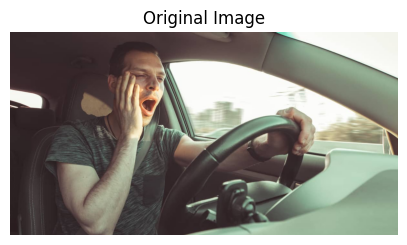

No face detected or image is already cropped. Using full image.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction: yawn
Confidence: 0.5661
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction: yawn
Confidence: 0.5661


In [4]:
# CNN Image-based demo: predict using a trained CNN model on a sample image
import os
import cv2
import numpy as np

model_path = "models/drowsiness_cnn_trained.h5"
# prefer a repo sample image, otherwise try the dataset
img_path = "sample_images/driver1.png"
if not os.path.exists(img_path):
    data_dir = "data/drowsiness"
    if os.path.exists(data_dir):
        for cat in ["yawn", "no_yawn", "Closed", "Open"]:
            folder = os.path.join(data_dir, cat)
            if os.path.exists(folder) and len(os.listdir(folder)) > 0:
                img_path = os.path.join(folder, os.listdir(folder)[0])
                break

if not os.path.exists(img_path):
    print("No sample image found. Place one at 'sample_images/driver1.png' or add the dataset.")
else:
    print(f"Using image: {img_path}")

    # If the notebook already defines `predict_image`, call it for consistent behavior
    try:
        predict_image  # noqa: F821
    except NameError:
        predict_image = None

    if predict_image:
        try:
            predict_image(img_path, model_path=model_path)
        except Exception as e:
            print("predict_image helper raised:", e)
    else:
        # fallback: load model and run a minimal predict flow
        try:
            from tensorflow.keras.models import load_model
            from drowsiness.cnn_utils import get_haarcascade_path, crop_mouth_from_face
        except Exception as e:
            print("Required CNN utilities or keras not available:", e)
            raise

        if not os.path.exists(model_path):
            print(f"Model not found at: {model_path}. Please train or provide the trained model.")
        else:
            model = load_model(model_path)
            IMG_SIZE = 145

            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to read image: {img_path}")
            else:
                face_cas_path = get_haarcascade_path()
                cropped = crop_mouth_from_face(img, face_cas_path)
                if cropped is not None:
                    input_img = cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
                else:
                    input_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                normalized = input_img / 255.0
                reshaped = normalized.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

                prediction = model.predict(reshaped)
                labels = ["yawn", "no_yawn", "Closed", "Open"]
                class_idx = int(np.argmax(prediction))
                print(f"Prediction: {labels[class_idx]}")
                print(f"Confidence: {prediction[0][class_idx]:.4f}")

                # Show the image inline if running interactively
                try:
                    import matplotlib.pyplot as plt
                    plt.figure(figsize=(4, 4))
                    plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.show()
                except Exception:
                    pass

### WebCam demo
This pipeline uses the trained CNN model (`CNNDrowsinessDetector`) to classify frames as drowsy/yawning and reuses the same webcam loop helper. Use this when you want a learned model instead of landmark thresholds.

In [ ]:
from drowsiness.cnn_analyzer import CNNDrowsinessDetector
from drowsiness.utils import run_drowsiness_detection_loop

# Run the detection loop with dlib-based analyzer
detector = CNNDrowsinessDetector('models/drowsiness_cnn.h5')
run_drowsiness_detection_loop(
    analyzer=detector,
    window_name="Drowsiness Detection",
    use_mediapipe=False
)

# Logs analysis of previously scanned history

Loaded 42 events from logs/drowsiness_log.csv
Total events: 42
2025-11-14: Yawn Detected: 11, Drowsiness Detected: 20
2025-11-23: Drowsiness Detected: 1, Yawn Detected: 1
2025-12-13: Yawn Detected: 5, Drowsiness Detected: 4


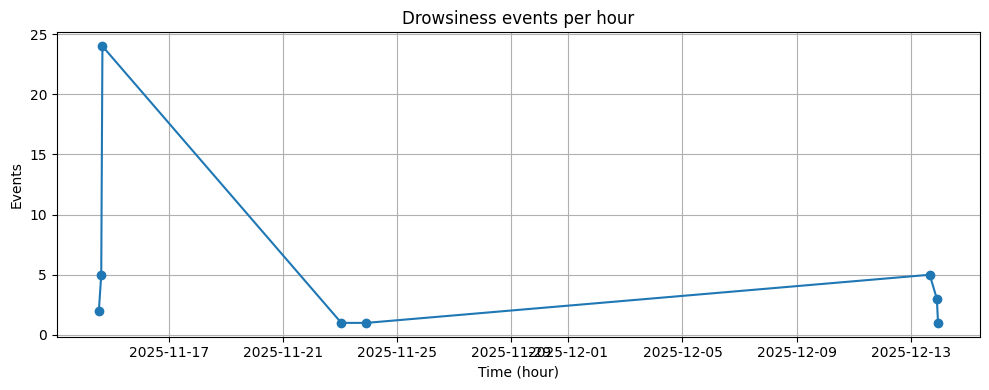

Most recent event: 2025-12-13 23:28:37 Drowsiness Detected
No screenshot available for this event.


In [3]:
# Log analysis demo: read logs, print a summary, plot timeline, and show latest thumbnail (if available)
from tools import log_analysis

log_file = 'logs/drowsiness_log.csv'
events = log_analysis.read_logs(log_file)

print('Loaded', len(events), 'events from', log_file)

# Print a compact summary
log_analysis.print_summary(events)

# If matplotlib is available, plot a simple timeline
try:
    log_analysis.plot_timeline(events)
except Exception as e:
    print('Plotting unavailable or failed:', e)

# Show the thumbnail for the most recent event if one exists
if events:
    latest = events[-1]
    print('Most recent event:', latest['timestamp'].strftime('%Y-%m-%d %H:%M:%S'), latest['event'])
    try:
        log_analysis.show_event_thumbnail(latest)
    except Exception as e:
        print('Thumbnail display unavailable or failed:', e)
else:
    print('No events found in the log file.')
